In [1]:
%matplotlib nbagg
%matplotlib inline
import MDAnalysis as mda
import MDAnalysis.analysis.leaflet
import matplotlib
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import nglview as nv

import warnings
warnings.filterwarnings('ignore')

# name and files for the simulation studied

name = '_DPPC_DIPC_chol_352'

path = '/users/cornet/Documents/PhD/Matthieu/3-5-2/sans_GM1/'

fgro = 'start_mb.gro'
fxtc = 'run_DPPC_DIPC_CHOL_43nm_352_mb_fixed_t1.xtc'

In [2]:
# indicate the name of the simulation, the path of the data and the .gro and .xtc files to import

name = '_DPPC_DIPC_chol_352_5GM1'

path = '/home/julie/analysis/bilayers/3-5-2/DPPC_DIPC_chol_GM1_5/'

fgro = 'run_DPPC_DIPC_CHOL_GM1_5_43nm_10ms_mb_fixed_t1_ref9999ns.gro'
fxtc = 'run_DPPC_DIPC_CHOL_GM1_5_43nm_10ms_mb_fixed_t1.xtc'

In [3]:
# load gro and xtc files
u = mda.Universe( path+fgro, path+fxtc)

In [4]:
sel_all = u.select_atoms("all and resname DPPC")

In [6]:
# visualize the bilayer and choose the frame to study

v= nv.show_mdanalysis(sel_all)
v.add_spacefill(sel_all, scale=2.0)
v

A Jupyter Widget

In [12]:
# boucle pour calculer la distribution de compo au cours du temps

tmes = 500
start = 5000
nb_bin = 20

nb_rate = np.zeros(nb_bin+1)
rate = np.arange(nb_bin+1)/nb_bin + 1/2/nb_bin

for ts in u.trajectory:
     if (ts.frame%tmes == 0 and ts.frame>=start):
            print(ts.frame)
            xmin=0
            ymin=0
            str_sel= "(prop x> "+str(xmin)+" and prop y> "+str(ymin)+") and (name GL1 or name AM1)"
            patch = u.select_atoms(str_sel).positions
            
            xmax = max(patch[:,0])
            ymax = max(patch[:,1])
            
            xmin = min(patch[:,0])
            ymin = min(patch[:,1])
            
            N = 15
            dx = (xmax-xmin)/N
            dy = (ymax-ymin)/N
           
            Lf = mda.analysis.leaflet.LeafletFinder(u, 'name PO4 or name GM1')
            leaflet0 = Lf.groups(0)
            leaflet1 = Lf.groups(1)
                    
            # upper leaflet
            bary0 = []

            Mphi0_Lo = np.zeros((N,N))

            for i in range(0,N):
                xs = xmin + i*dx
                for j in range(0,N):
                    ys = ymin + j*dy

                    # barycenter of all molecules in each box
                    str_sel= "(prop x>= "+str(xs)+" and prop x< "+str(xs+dx)+" and prop y>= "+str(ys)+" and prop y< "+str(ys+dy)+")"
                    b0=leaflet0.select_atoms(str_sel).centroid().tolist()
                    bary0.append(b0)

                    # composition rates in each box
                    sel_tot= "(prop x>= "+str(xs)+" and prop x< "+str(xs+dx)+" and prop y>= "+str(ys)+" and prop y< "+str(ys+dy)+") and name PO4"
                    tot0= leaflet0.select_atoms(sel_tot).positions
                    n_tot0=len(tot0) # total number of molecules

                    sel_Lo= "(prop x>= "+str(xs)+" and prop x< "+str(xs+dx)+" and prop y>= "+str(ys)+" and prop y< "+str(ys+dy)+") and resname DPPC"
                    Lo0= leaflet0.select_atoms(sel_Lo).positions
                    n_Lo0=len(Lo0) # number of molecules of the Lo phase (DPPC here)

                    phi0_Lo=n_Lo0/n_tot0
  
                    Mphi0_Lo[i,j]=phi0_Lo


            bary0=np.array(bary0)
            
            for i in range(N):
                for j in range(N):
                    r = int(np.floor(nb_bin*Mphi0_Lo[i,j]))
                    nb_rate[r]+=1
nb_rate = nb_rate/((10000-start)/tmes)

5000
5500
6000
6500
7000
7500
8000
8500
9000
9500


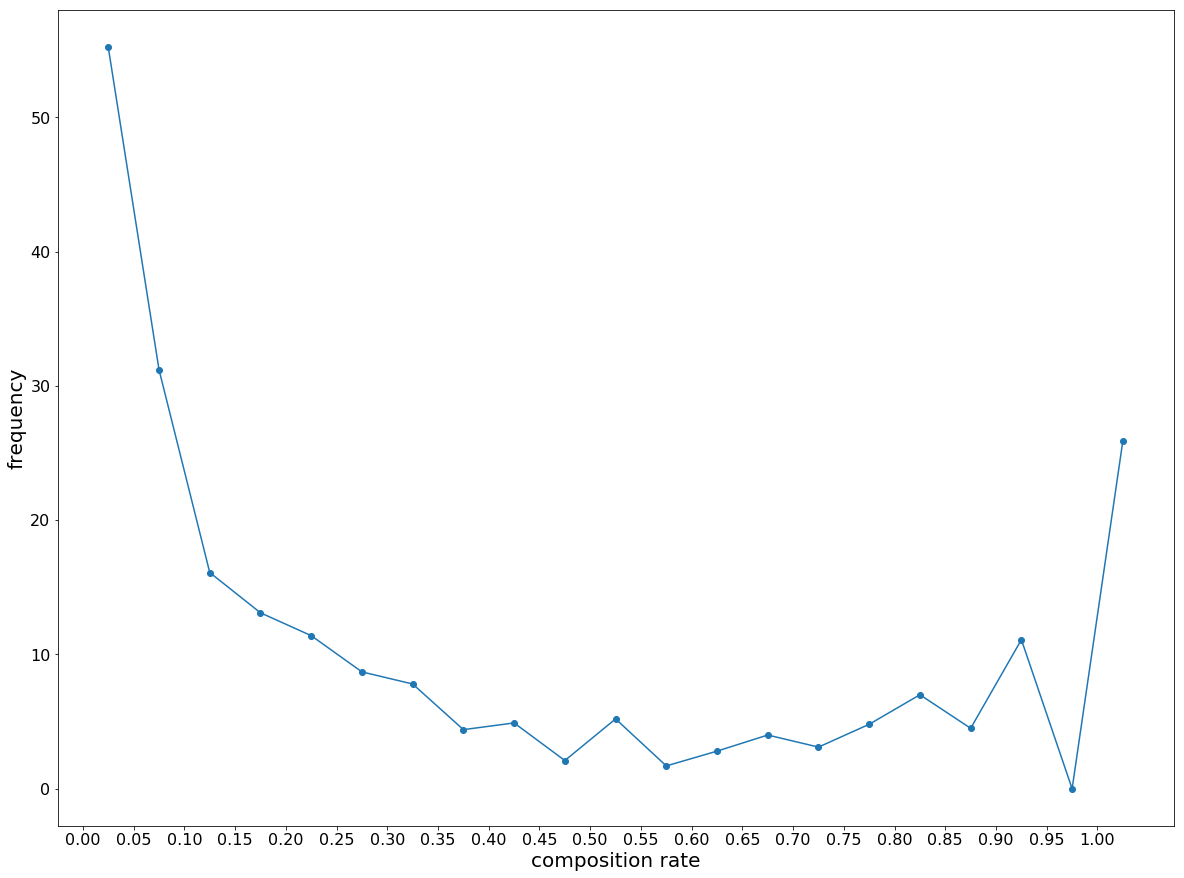

In [13]:
fig, ax=plt.subplots(figsize=(20,15))
plt.plot(rate, nb_rate,'-o')
plt.xticks(np.arange(0, 1.05, step=0.05))
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('composition rate',fontsize=20)
plt.ylabel('frequency',fontsize=20)
plt.savefig(path+'compo_dist2'+name+'.pdf', format='pdf',bbox_inches='tight')